# Working example
The only purpose of this network is to have a working example. This, with minor modifications, should still work after modifications. In a way this is to ensure that no matter the modifications the networks is still doing the same

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '4a6a1a858fcdf991f6e37f8c175873dcbc258e57'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns

from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_state_variables_vs_time

from analysis_functions import calculate_total_connections, calculate_connections_free_attractor_to_first_pattern
from analysis_functions import calculate_connections_last_pattern_to_free_attractor
from analysis_functions import calculate_connections_among_free_attractor
from analysis_functions import calculate_connections_first_pattern_to_free_attractor

from analysis_functions import calculate_recall_success

#### Let's build the network

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30

# Manager properties
dt = 0.001
T_recalling = 5.0
values_to_save = ['o', 's', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w',
                  'p', 'k_d']
    
# Protocol
training_time = 0.1
inter_sequence_interval = 2.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)

nn.k_inner = False


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [0, 1, 2, 3 ,4]
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

# Train
epoch_history = manager.run_network_protocol(protocol=protocol, verbose=True, values_to_save_epoch=['w'])

('epochs', 0)
('epochs', 1)
('epochs', 2)


#### Plots 

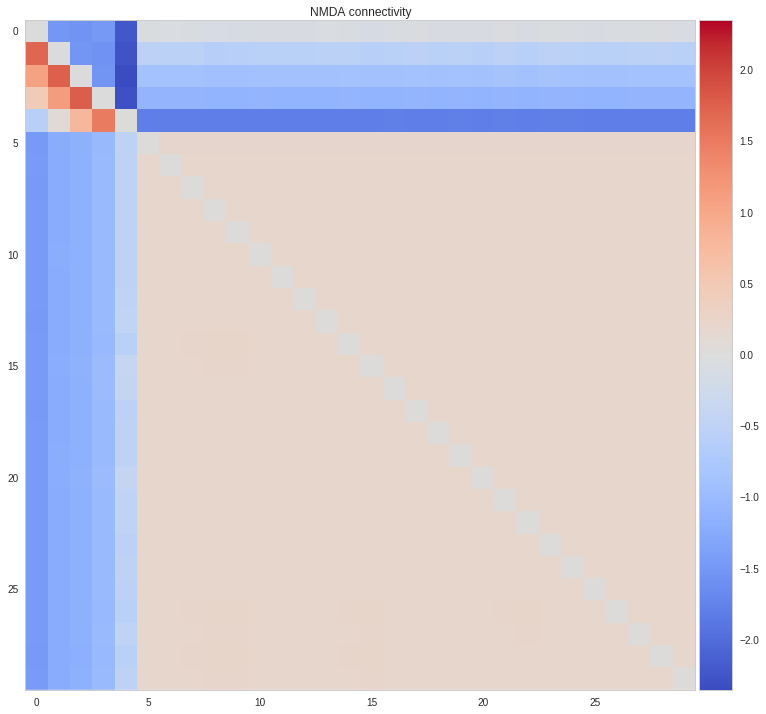

In [5]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)

../analysis_functions.py:43: RuntimeWarning: invalid value encountered in double_scalars
  dis = [a / b for (a, b) in zip(nominator, denominator)]


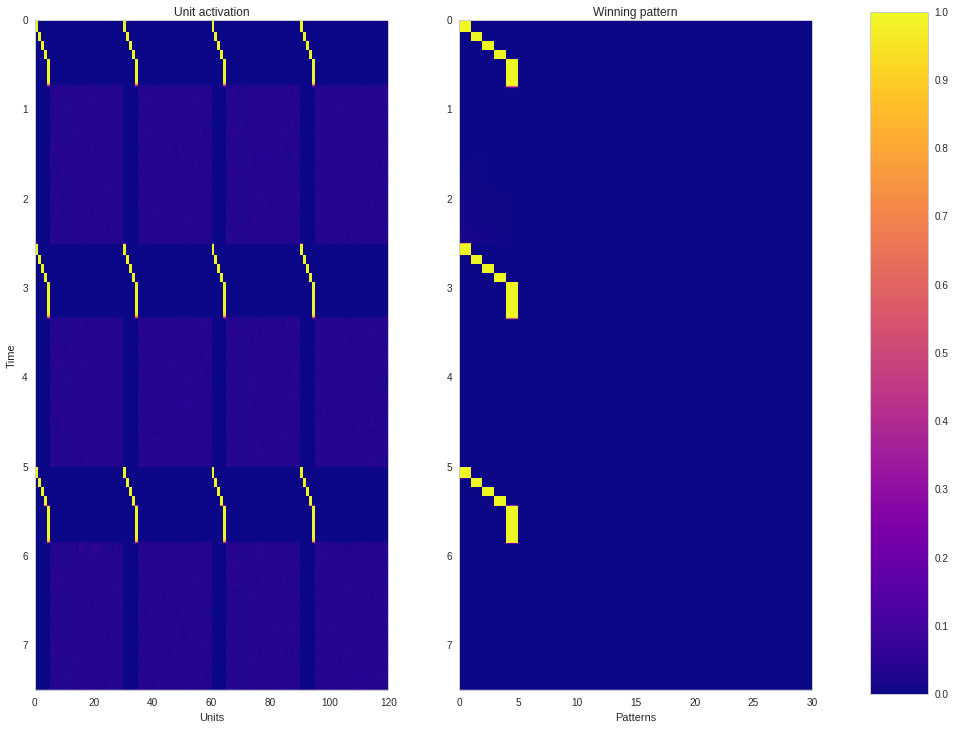

In [6]:
plot_network_activity_angle(manager)

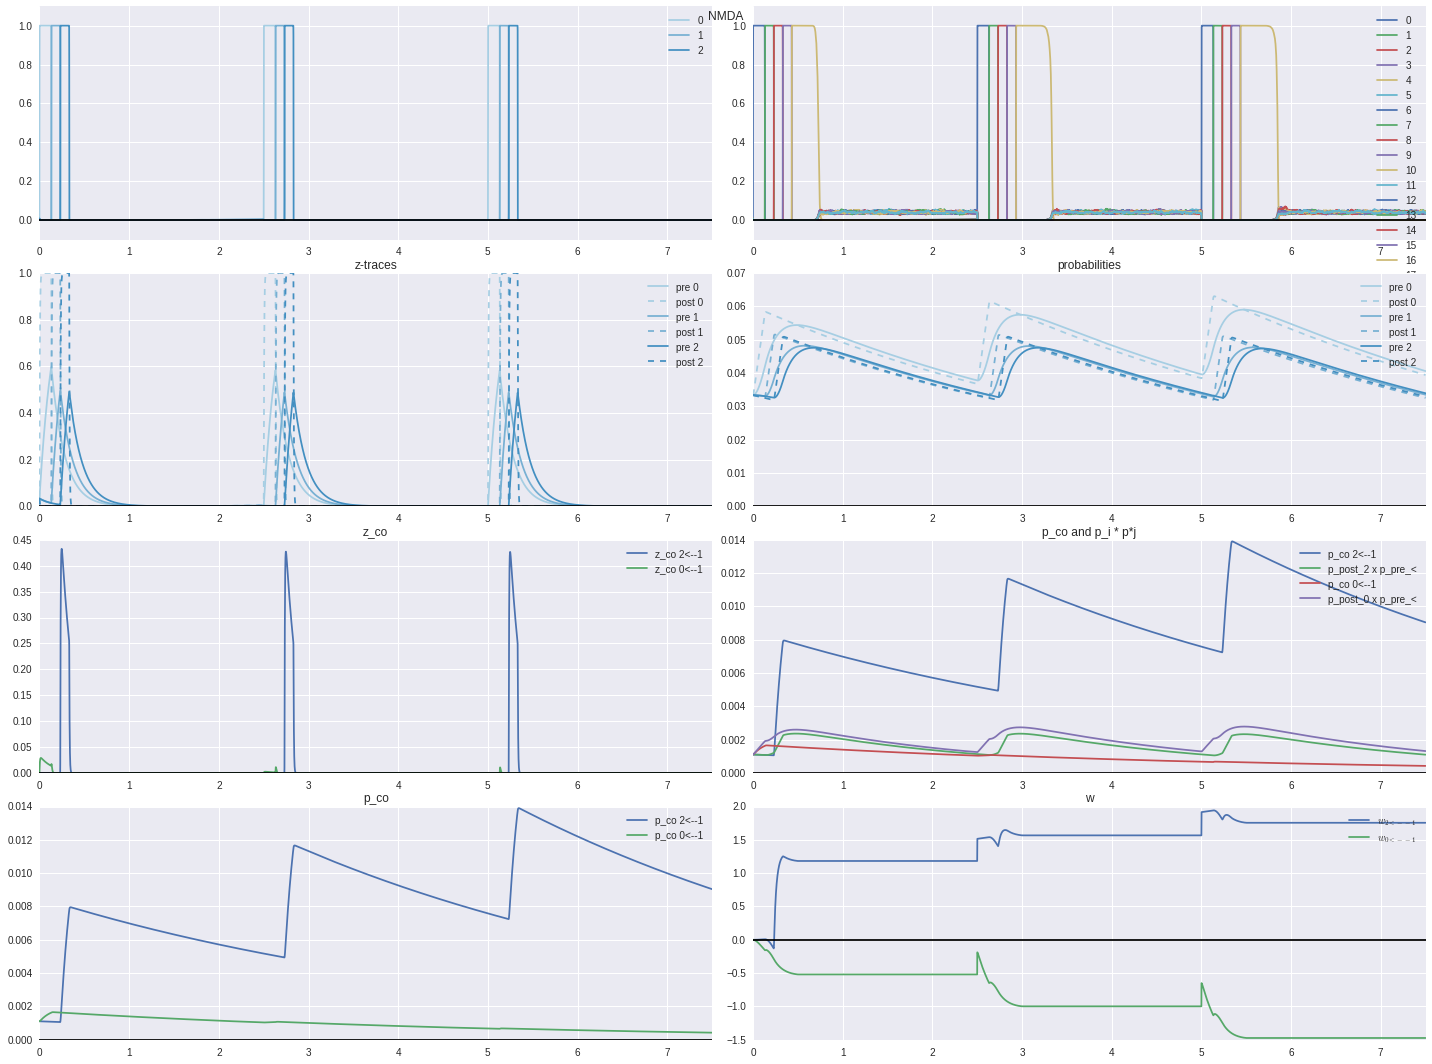

In [7]:
plot_state_variables_vs_time(manager, traces_to_plot=[0, 1, 2], ampa=False)

#### Connectivity and recall calculations

We do connectivity calculations, the connectivity values should be only positive for the total connectivity and among the free attractor

In [8]:
ampa = False
normalize = True

total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
escape = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

print('total connectivity', total)
print('sequence to attractor', seq_to_attractor)
print('attractor to sequence', attractor_to_seq)
print('connections among the free attractor', inter_free_attractor)
print('First to free attractor', escape)

total connectivity 1.70722843976
sequence to attractor -0.488895265464
attractor to sequence -0.0789763359528
connections among the free attractor 0.203662516559
First to free attractor -1.44722338616


The recall should be 100%

In [ ]:
success_rate = calculate_recall_success(manager, T_recalling=T_recalling,
                                       I_cue=0, T_cue=0.1, n=15, patterns_indexes=patterns_indexes)
print('success rate', success_rate)

#### Git recover

In [ ]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])